Highlight differences between moslin / LineageOT
---

- Visualize the difference in ancestor & descendant error
- zoom into one cluster and highlight the difference in the actual couplings. 

# Preliminaries

## Import packages

In [1]:
import utils
import scanpy as sc
import scvelo as scv
import moscot as mc
import pickle
import numpy as np
import ot
import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import sys
from typing import Union, List, Optional, Literal

Print the moscot version. 

In [2]:
mc.__version__

'0.2.1.dev10+g68c10a0'

## Dependencies

This notebook depends on [ML_2023-03-31_moslin_abpxp.ipynb](ML_2023-03-31_moslin_abpxp.ipynb) and on [ML_2023-03-31_prepare_data.ipynb](ML_2023-03-31_prepare_data.ipynb). 

## Set up paths

Define the paths for data and figures

In [3]:
sys.path.insert(
    0, "../../"
)  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, FIG_DIR

FIG_DIR = FIG_DIR / "packer_c_elegans"
DATA_DIR = DATA_DIR / "packer_c_elegans"

Set up the paths to save figures.

In [4]:
scv.settings.figdir = str(FIG_DIR)
sc.settings.figdir = str(FIG_DIR)

## Define utility functions

Compute EMD distances between the rows or columns of two matrices, given a cost. 

In [5]:
def _compute_w2(
    P_pred: np.array,
    P_gt: np.array,
    C: np.array,
    metric_type: Literal["descendant", "ancestor"],
    scale_by_marginal: bool = True,
) -> List:
    # initialize an empty list to store the errors per cell
    errors = []

    # transpose for ancestors
    if metric_type == "ancestor":
        P_pred = P_pred.T
        P_gt = P_gt.T

    # iterate over all cells
    for i in tqdm.tqdm(range(P_pred.shape[0])):
        # normalize to get distributions
        marginal = P_pred[i].sum()
        p = P_pred[i] / marginal
        g = P_gt[i] / P_gt[i].sum()

        # compute the EMD distance between ground-truth and predicted distibution
        error, log = ot.emd2(p, g, C, log=True)

        # append the EMD (potentially scaled by the marignal)
        if log["warning"] is None:
            if scale_by_marginal:
                errors.append(marginal * error)
            else:
                errors.append(error)
        else:
            errors.append(np.nan)

    return errors

Call the `_compute_w2` function to compute both ancestor and descendant errors. 

In [6]:
def compute_errors(
    pred: np.ndarray, gt: utils.CouplingInfo, scale_by_marginal: bool = True
):
    # check that the shapes match
    assert pred.shape == gt.coupling.shape

    # compute the ancestor errors
    ancestor_errors = _compute_w2(
        P_pred=pred,
        P_gt=gt.coupling,
        C=gt.early_rna_cost,
        metric_type="ancestor",
        scale_by_marginal=scale_by_marginal,
    )

    # compute the descendant errors
    descendant_errors = _compute_w2(
        P_pred=pred,
        P_gt=gt.coupling,
        C=gt.late_rna_cost,
        metric_type="descendant",
        scale_by_marginal=scale_by_marginal,
    )

    return ancestor_errors, descendant_errors

Visualize the difference between moslin and LineageOT in terms of ancestor and descendant error in an embedding. 

In [7]:
def plot_ancestor_descendant_error(adata, save: Optional[str] = None):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), dpi=300)
    vmax = adata.obs["diff_early_error"].abs().max()

    sc.pl.umap(
        adata,
        vmin=-vmax,
        vmax=vmax,
        ax=ax0,
        show=False,
        frameon=False,
        alpha=0.6,
        size=80,
    )

    sc.pl.umap(
        adata[adata.obs["time"] == LATE_TP],
        color=["diff_early_error"],
        cmap="seismic",
        vmin=-vmax,
        vmax=vmax,
        add_outline=True,
        ax=ax0,
        show=False,
        frameon=False,
        alpha=0.6,
        size=80,
    )

    vmax = adata.obs["diff_late_error"].abs().max()
    sc.pl.umap(
        adata,
        vmin=-vmax,
        vmax=vmax,
        ax=ax1,
        show=False,
        frameon=False,
        alpha=0.6,
        size=80,
    )
    sc.pl.umap(
        adata[adata.obs["time"] == EARLY_TP],
        color=["diff_late_error"],
        cmap="seismic",
        vmin=-vmax,
        vmax=vmax,
        ax=ax1,
        show=False,
        add_outline=True,
        frameon=False,
        alpha=0.6,
        size=80,
    )

    ax0.set_title("$\Delta$ ancestor error")
    ax1.set_title("$\Delta$ descendant error")
    fig.tight_layout()

    if save is not None:
        plt.savefig(FIG_DIR / save)

    return fig

Visualize lines connecting cells in an embedding. 

In [8]:
def plot2D_samples_mat(ax, xs, xt, G, thr=1e-8, alpha_scale=1, **kwargs):
    mx = G.max()
    sources = []
    targets = []
    for i in range(xs.shape[0]):
        for j in range(xt.shape[0]):
            val = G[i, j] / mx
            if val > thr:
                ax.plot(
                    [xs[i, 0], xt[j, 0]],
                    [xs[i, 1], xt[j, 1]],
                    alpha=alpha_scale * val,
                    **kwargs
                )
                sources.append(i)
                targets.append(j)
    return sources, targets

Call the `plot2D_samples_mat` function to visualize moslin and LineageOT's predicted couplings via lines in an embedding. 

In [9]:
def plot_coupling(
    adata,
    coupling: np.ndarray,
    mask: Optional[List[bool]] = None,
    cats: Optional[Union[str, List[str]]] = None,
    key: Optional[str] = None,
    line_color: str = "k",
    dot_color: str = "lineage",
    thr: float = 0.1,
    alpha_scale: float = 0.6,
    ax=None,
):
    if ax is None:
        fig, ax = plt.subplots()
    emb = adata.obsm["X_umap"]

    src_mask = adata.obs["time"] == EARLY_TP
    tgt_mask = adata.obs["time"] == LATE_TP
    emb_src = adata.obsm["X_umap"][src_mask]
    emb_tgt = adata.obsm["X_umap"][tgt_mask]

    if mask is None:
        print(f"Using the {key} for subsetting")
        if isinstance(cats, str):
            cats = [cats]
        final_mask = adata[src_mask].obs[key].isin(cats)
    else:
        print(f"Using the mask for subsetting")
        final_mask = mask[src_mask]

    coupling = coupling[final_mask, :]
    emb_src = emb_src[final_mask]

    sc.pl.umap(adata, frameon=False, alpha=0.6, size=80, ax=ax, show=False, zorder=0)

    # draw the lines
    src, tgt = plot2D_samples_mat(
        ax,
        emb_src,
        emb_tgt,
        coupling,
        thr=thr,
        alpha_scale=alpha_scale,
        zorder=1,
        color=line_color,
    )
    # outline source points
    sc.pl.umap(
        adata[src_mask][final_mask][np.unique(src), :],
        color=dot_color,
        legend_loc="none",
        alpha=0.3,
        frameon=False,
        size=80,
        ax=ax,
        show=False,
        add_outline=True,
    )
    # outline target points
    sc.pl.umap(
        adata[tgt_mask][np.unique(tgt), :],
        color=dot_color,
        legend_loc="none",
        alpha=0.3,
        frameon=False,
        size=80,
        ax=ax,
        show=False,
        add_outline=True,
    )

    if ax is None:
        fig.tight_layout()
        return fig

Use a DataFrame containing gridsearch results to return the optimal hyperparameters per method. 

In [10]:
def prepare_df(
    df: pd.DataFrame,
    *,
    lineage_info: Literal["precise", "abpxp"],
    method: Literal["moslin", "lot"] = "moslin",
    early_tp: float,
    late_tp: float,
) -> pd.DataFrame:
    """Extract optimal hyperparameters from gridsearch"""

    # Filter to a subsampling strategy, and the method used to compute the coupling
    df = df.loc[df["config.lineage_info"] == lineage_info].copy()
    df = df.loc[df["config.kind"] == method].copy()
    df = df.loc[df["config.tp"] == f"[{early_tp}, {late_tp}]"].copy()

    # Compute the mean cost and find the minimum
    df["mean_cost"] = (df["result.early_cost"] + df["result.late_cost"]) / 2.0
    ixs = df.groupby(["config.kind", "config.tp"])["mean_cost"].idxmin()
    df = df.loc[ixs.reset_index()["mean_cost"]]

    # Prettify method names and time point labels
    df["config.kind"] = df["config.kind"].replace({"lot": "LineageOT"})

    return df

## Set global parameters

In [11]:
DPI_SAVE = 400

scv.settings.set_figure_params(
    "scvelo",
    dpi_save=DPI_SAVE,
    dpi=80,
    transparent=True,
    fontsize=20,
    color_map="viridis",
)
scv.settings.plot_prefix = ""

In [12]:
# should figures just be displayed or also saved?
save_figure = False

In [13]:
EARLY_TP, LATE_TP = 330, 390
TIME_KEY = "assigned_batch_time"
LINEAGE_INFO = "abpxp"

## Load and preprocess the data

Load AnnData objects, created in previous notebooks. 

In [14]:
# import the raw data, to re-compute the couplings
adata = sc.read(DATA_DIR / "ML_2023-04-11_c_elegans_prep.h5ad")

# import another AnnData object for the embedding etc.
adata_umap = sc.read(DATA_DIR / "ML_2023-04-11_c_elegans_abpxp_adata.h5ad")

Download the C. elegans lineage tree [(Packer et al., Science 2019)](https://www.science.org/doi/10.1126/science.aax1971) from [figshare](https://doi.org/10.6084/m9.figshare.c.6533377.v1). Subset to the ABpxp lineage, preprocess the data, compute PCA, and write the lineage tree to `.uns`. 

In [15]:
_, full_reference_tree = mc.datasets.c_elegans(DATA_DIR / "c_elegans")
adata = utils.preprocess(adata, full_reference_tree, lineage_info=LINEAGE_INFO, seed=0)

In addition, import the grid search results to inform our choice of hyperparematers. The results of our gridsearch are included in this repositroy in `data/packer_c_elegans`. 

In [16]:
grid_df = pd.read_csv(
    DATA_DIR / "MK_2023-02-27_celegans_precise_and_abpxp.csv", index_col=0
)

# filter to runs that converged
grid_df = grid_df.loc[grid_df["result.converged"]]
grid_df.shape

(432, 13)

# Compute the couplings

## Run moslin

Use the hyperparameters found during the gridsearch:

In [17]:
moslin_params = prepare_df(
    grid_df,
    early_tp=EARLY_TP,
    late_tp=LATE_TP,
    lineage_info=LINEAGE_INFO,
    method="moslin",
)

moslin_alpha = moslin_params["config.alpha"].values[0]
moslin_epsilon = moslin_params["config.epsilon"].values[0]
moslin_scale_cost = moslin_params["config.scale_cost"].values[0]

Run the actual moslin method. 

In [18]:
prob, pred_mos, conv_mos, gt = utils.benchmark_moscot(
    adata,
    EARLY_TP,
    LATE_TP,
    alpha=moslin_alpha,
    epsilon=moslin_epsilon,
    scale_cost=moslin_scale_cost,
)
assert conv_mos
adata_mos = prob.adata
gt.cost(pred_mos, late=False), gt.cost(pred_mos, late=True)

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1874, 855)].                                   


(0.33669206407051505, 0.2944518819688411)

## Run LineageOT

Extract the hpyerparameters for LineageOT

In [19]:
lot_params = prepare_df(
    grid_df, early_tp=EARLY_TP, late_tp=LATE_TP, lineage_info=LINEAGE_INFO, method="lot"
)

lot_epsilon = lot_params["config.epsilon"].values[0]
lot_scale_cost = lot_params["config.scale_cost"].values[0]

Run the actual LineageOT method. 

In [20]:
pred_lot, conv_lot, _ = utils.benchmark_lot(
    adata,
    EARLY_TP,
    LATE_TP,
    epsilon=lot_epsilon,
    scale_cost=lot_scale_cost,
)
assert conv_lot
gt.cost(pred_lot, late=False), gt.cost(pred_lot, late=True)

(0.5969905268780584, 0.5394833520059986)

## Compute ancestor/descendant errors

Compute error metrics for LineageOT. 

In [21]:
anc_lot, des_lot = compute_errors(pred_lot, gt, scale_by_marginal=False)

100%|█████████████████████████████████████████████████████████| 1874/1874 [00:07<00:00, 254.23it/s]


Compute error metrics for moslin. 

In [22]:
anc_mos, des_mos = compute_errors(pred_mos, gt, scale_by_marginal=False)

100%|█████████████████████████████████████████████████████████| 1874/1874 [00:07<00:00, 267.25it/s]


Write the resulting errors, and differences in erorrs, back to AnnData

In [23]:
# write the error for LineageOT
adata_mos.obs["lot_error"] = anc_lot + des_lot  # assumes t1 < t2 always
adata_mos.obs["lot_early_error"] = np.nan
adata_mos.obs.loc[
    adata_mos.obs_names[(adata_mos.obs["time"] == LATE_TP)], "lot_early_error"
] = anc_lot
adata_mos.obs["lot_late_error"] = np.nan
adata_mos.obs.loc[
    adata_mos.obs_names[(adata_mos.obs["time"] == EARLY_TP)], "lot_late_error"
] = des_lot

# write the error for moslin
adata_mos.obs["moslin_error"] = anc_mos + des_mos  # assumes t1 < t2 always
adata_mos.obs["moslin_early_error"] = np.nan
adata_mos.obs.loc[
    adata_mos.obs_names[(adata_mos.obs["time"] == LATE_TP)], "moslin_early_error"
] = anc_mos
adata_mos.obs["moslin_late_error"] = np.nan
adata_mos.obs.loc[
    adata_mos.obs_names[(adata_mos.obs["time"] == EARLY_TP)], "moslin_late_error"
] = des_mos

# compute the difference in errors, for ancestors and descendants.
adata_mos.obs["diff_error"] = adata_mos.obs["lot_error"] - adata_mos.obs["moslin_error"]
adata_mos.obs["diff_early_error"] = (
    adata_mos.obs["lot_early_error"] - adata_mos.obs["moslin_early_error"]
)
adata_mos.obs["diff_late_error"] = (
    adata_mos.obs["lot_late_error"] - adata_mos.obs["moslin_late_error"]
)

# Visualize the zoom in

## Transfer Annotations

In [24]:
bdata = adata_mos.copy()

Copy over the UMAP embedding

In [25]:
shared_cells = bdata.obs_names.intersection(adata_umap.obs_names)
umap = pd.DataFrame(adata_umap[shared_cells].obsm["X_umap"], index=shared_cells)

In [26]:
mask = bdata.obs_names.isin(adata_umap.obs_names)
bdata.obsm["X_umap"] = np.full((bdata.n_obs, 2), fill_value=np.nan)
bdata.obsm["X_umap"][mask] = adata_umap[bdata.obs_names[mask]].obsm["X_umap"]

Copy cluster annotations and colors

In [27]:
cols = ["clusters", "coarse_clusters", "time_point"]

for col in cols:
    if col in bdata.obs.keys():
        del bdata.obs[col]

new_obs = bdata.obs.join(other=adata_umap.obs[cols], how="left")
assert new_obs.shape[0] == bdata.obs.shape[0], "Mismatch in the number of cells"

# assign the new .obs attribute
bdata.obs = new_obs.loc[bdata.obs_names]

Also take care of the colors

In [28]:
for col in cols:
    bdata.uns[f"{col}_colors"] = adata_umap.uns[f"{col}_colors"]

Visualize cluster annotations on this data subset. 

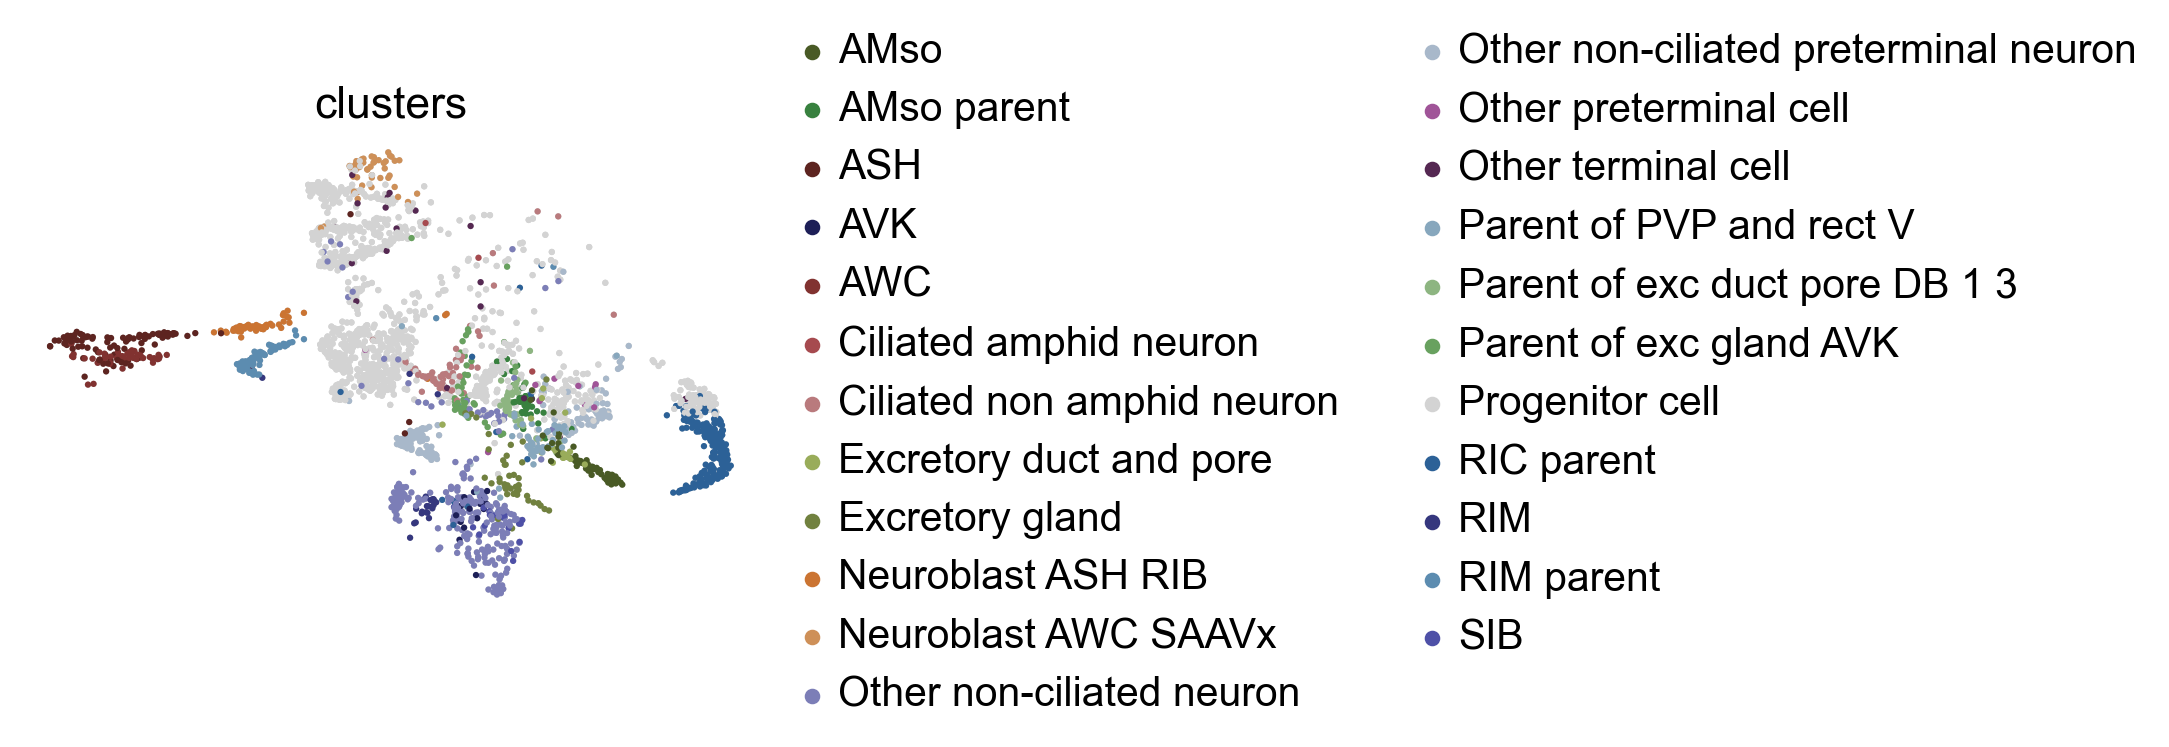

In [29]:
fig_kwargs = {}
if save_figure:
    fig_kwargs["save"] = "umap_330_390_clusters.pdf"

scv.pl.scatter(bdata, c="clusters", legend_loc="right", **fig_kwargs)

## Visualize the ancestor and descendant error

Plot the actual error differences in the UMAP. 

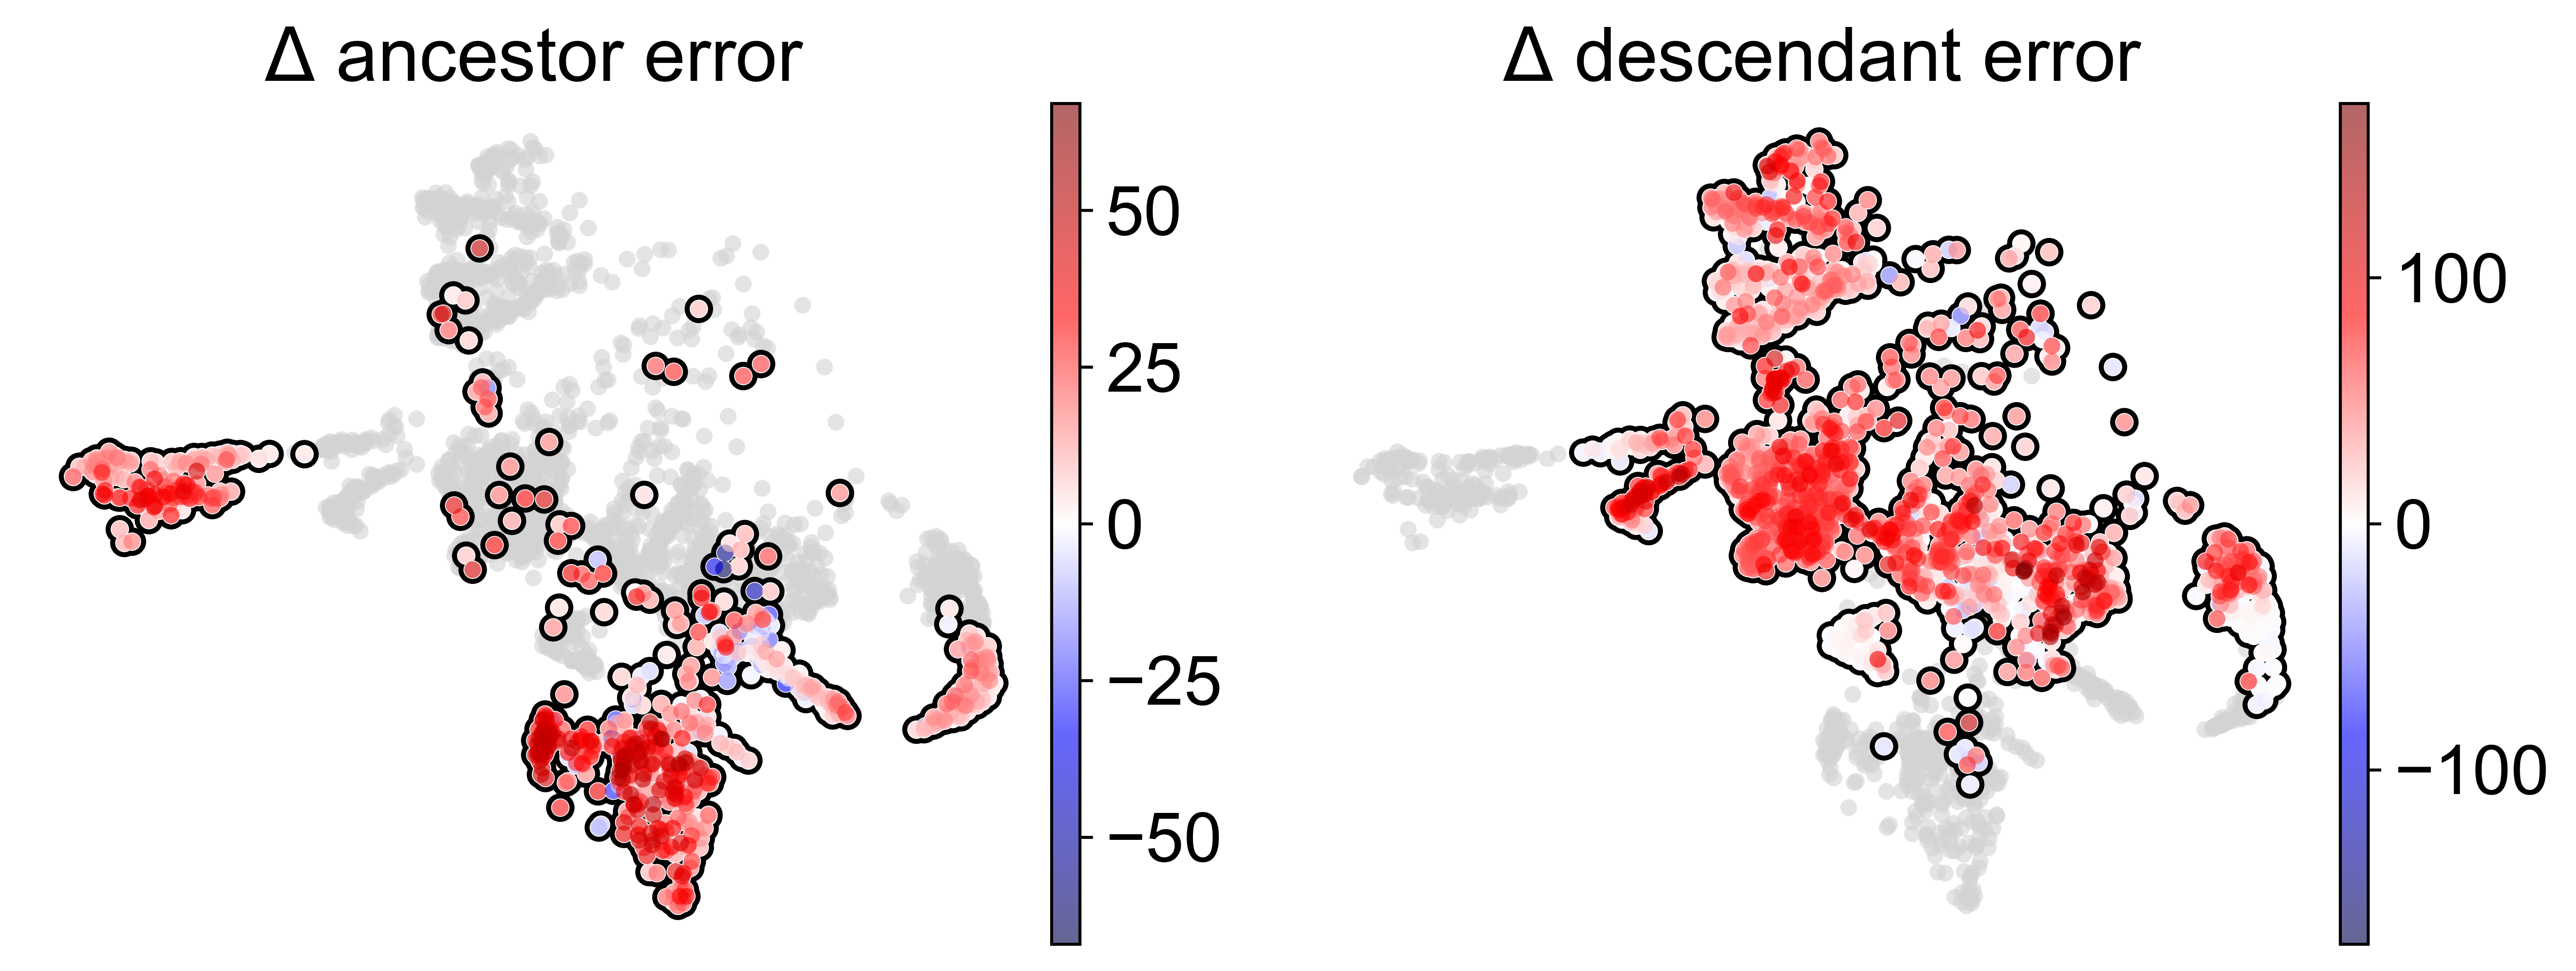

In [30]:
fig_kwargs = {}
if save_figure:
    fig_kwargs["save"] = "umap_delta_error.pdf"

fig = plot_ancestor_descendant_error(bdata, **fig_kwargs)

## Visualize coupling for target population

I would like to focus on the `RIM_parent` population: 

In [31]:
target = "RIM_parent"
mask_1 = bdata.obs["plot.cell.type"] == target

bdata[mask_1].obs["lineage"].value_counts()

ABpxppaapa    80
ABpxpapapa     2
ABpxpaappa     1
ABpxpapaaa     1
ABpxpapap      1
Name: lineage, dtype: int64

Let's define a second mask to fix the major lineage here:

In [32]:
mask_2 = bdata.obs["lineage"] == "ABpxppaapa"
mask = np.logical_and(mask_1, mask_2)
np.sum(mask)

80

Highlight these cells on the umap: 

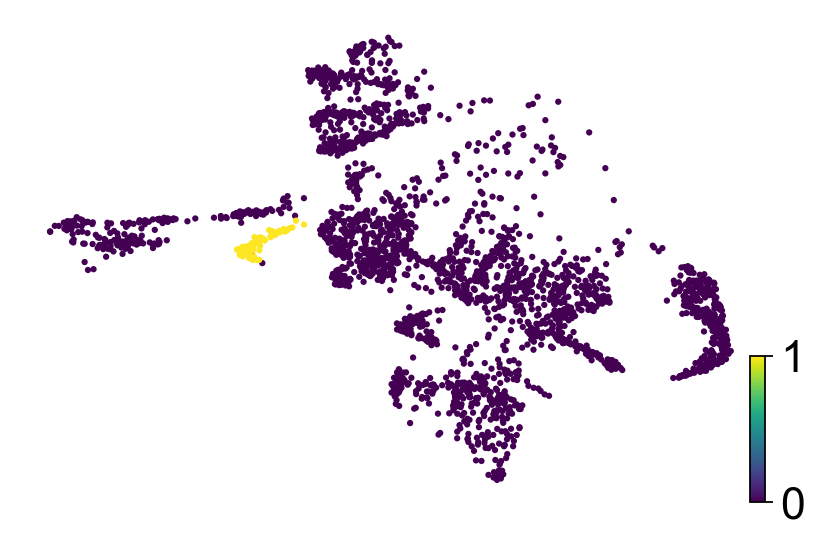

In [33]:
scv.pl.scatter(bdata, c=mask, color_map="viridis")

Visualize the ground-truth, and moslin/LineageOT-predicted couplings for this target population. 

Using the mask for subsetting
Using the mask for subsetting
Using the mask for subsetting


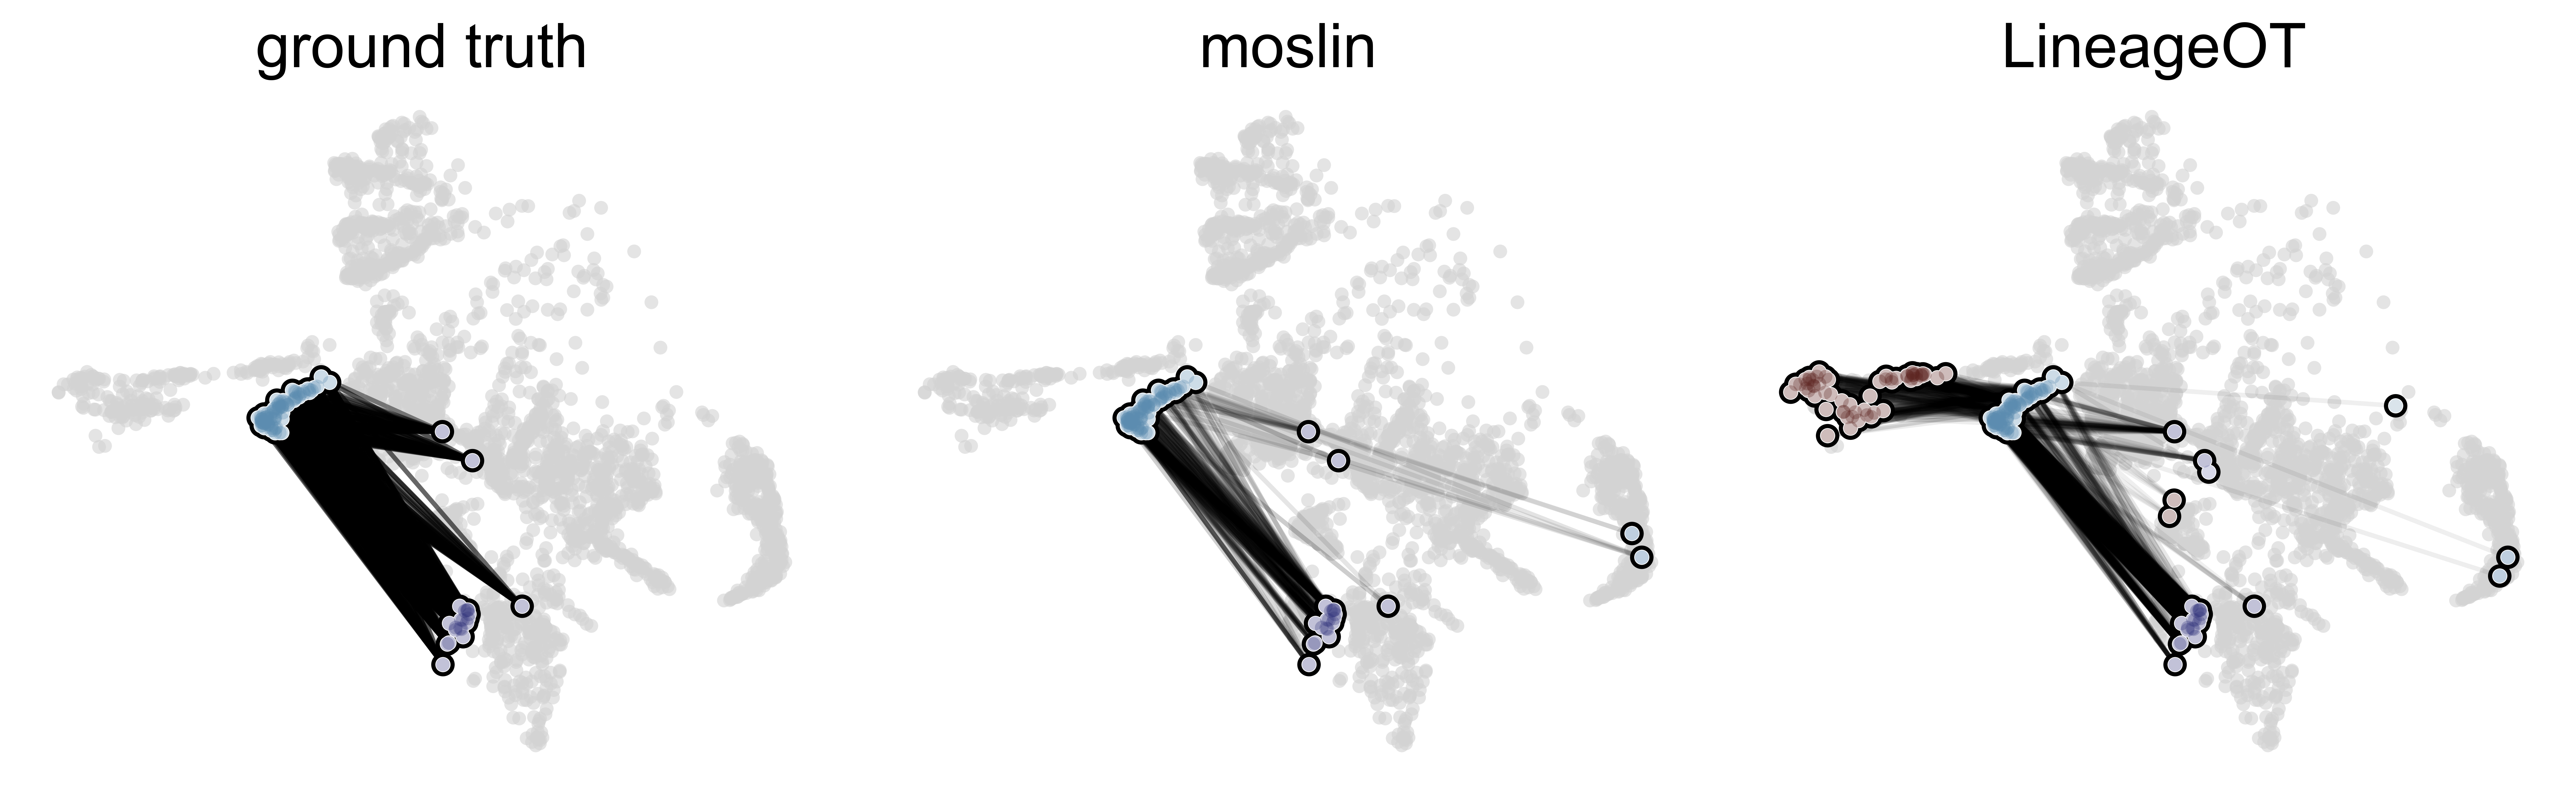

In [34]:
thr = 0.1
alpha_scale = 0.1

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4), dpi=DPI_SAVE)

common_kwargs = {"mask": mask, "thr": thr, "dot_color": "clusters", "alpha_scale": 0.6}

plot_coupling(bdata, gt.coupling, ax=ax0, **common_kwargs)
plot_coupling(bdata, pred_mos, ax=ax1, **common_kwargs)
plot_coupling(bdata, pred_lot, ax=ax2, **common_kwargs)

ax0.set_title("ground truth")
ax1.set_title("moslin")
ax2.set_title("LineageOT")

fig.tight_layout()

if save_figure:
    plt.savefig(FIG_DIR / "umap_couplings.pdf")

## Quantify descendant error over subpopulation

Quantify the mean descendant error over the `RIM_parent` population. Check that our mask still points to the correct set of cells. 

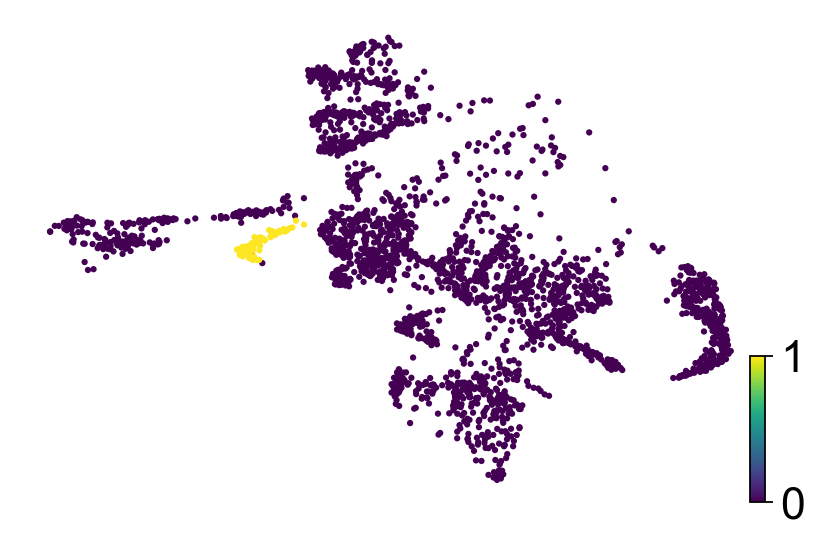

In [35]:
scv.pl.scatter(bdata, c=mask, color_map="viridis")

Restrict the target-population mask to early cells

In [36]:
# get a mask for early cells
src_mask = bdata.obs["time"] == EARLY_TP

# check that this maches the number of rows in the predicted coupoings
assert (
    np.sum(src_mask) == pred_mos.shape[0] == pred_lot.shape[0]
), "Shape mismatch between prediction and AnnData"

# subset the target mask to early cells
final_mask = mask[src_mask]

Re-compute descendant errors using marginal-scaling. 

In [37]:
_, des_lot_scaled = compute_errors(pred_lot, gt, scale_by_marginal=True)
_, des_mos_scaled = compute_errors(pred_mos, gt, scale_by_marginal=True)
_, des_ind_scaled = compute_errors(gt.ind_coupling, gt, scale_by_marginal=True)

100%|█████████████████████████████████████████████████████████| 1874/1874 [00:09<00:00, 203.15it/s]


Compute the mean descendant error over the target population and normalize with the independent coupling. 

In [38]:
target_error_lot = np.mean(np.array(des_lot_scaled)[final_mask]) / np.mean(
    np.array(des_ind_scaled)[final_mask]
)
target_error_mos = np.mean(np.array(des_mos_scaled)[final_mask]) / np.mean(
    np.array(des_ind_scaled)[final_mask]
)

Print both errors. 

In [39]:
print(
    f"LineageOT's mean descendant error over {target} cells is {target_error_lot:.2f}."
)
print(f"moslin's mean descendant error over {target} cells is {target_error_mos:.2f}.")

LineageOT's mean descendant error over RIM_parent cells is 0.80.
moslin's mean descendant error over RIM_parent cells is 0.26.
